<a href="https://colab.research.google.com/github/semihcinar/DataSecience/blob/main/Churn_Modelling_Keras_ANN_Classification_v01_cw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras Classification

<span class="girk">We have a dataset in which there are details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.</span>

---
---

## Import  libraries & data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (12, 6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings

warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)



In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path="/content/drive/MyDrive/DataSecience/Kaggle/Churn_Modelling.csv"

In [6]:
df = pd.read_csv(path, index_col='RowNumber')
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1
2,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
3,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
4,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


## Exploratory Data Analysis and Visualization

In [ ]:
 !pip install pandasgui

In [ ]:
from pandasgui import show

gui = show(df)

PandasGUI INFO — pandasgui.gui — Opening PandasGUI


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [ ]:
df.shape

(10000, 13)

In [ ]:
df.isnull().sum().any()

False

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.describe().T



,count,mean,std,min,25%,50%,75%,max
CustomerId,10000.000,15690940.569,71936.186,15565701.000,15628528.250,15690738.000,15753233.750,15815690.000
CreditScore,10000.000,650.529,96.653,350.000,584.000,652.000,718.000,850.000
Age,10000.000,38.922,10.488,18.000,32.000,37.000,44.000,92.000
Tenure,10000.000,5.013,2.892,0.000,3.000,5.000,7.000,10.000
Balance,10000.000,76485.889,62397.405,0.000,0.000,97198.540,127644.240,250898.090
NumOfProducts,10000.000,1.530,0.582,1.000,1.000,1.000,2.000,4.000
HasCrCard,10000.000,0.706,0.456,0.000,0.000,1.000,1.000,1.000
IsActiveMember,10000.000,0.515,0.500,0.000,0.000,1.000,1.000,1.000
EstimatedSalary,10000.000,100090.240,57510.493,11.580,51002.110,100193.915,149388.247,199992.480
Exited,10000.000,0.204,0.403,0.000,0.000,0.000,0.000,1.000


<AxesSubplot:>

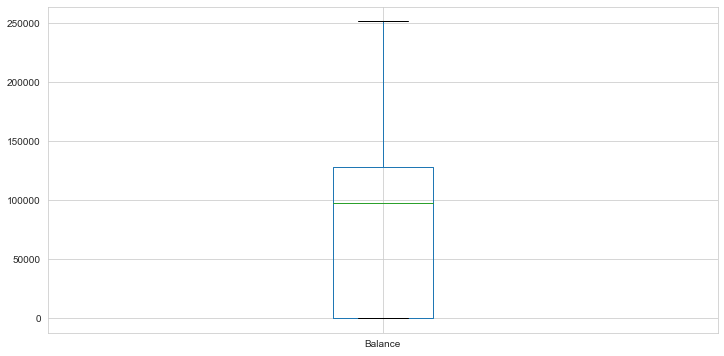

In [ ]:
df.Balance.plot(kind="box")

In [ ]:
df.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

0    7963
1    2037
Name: Exited, dtype: int64


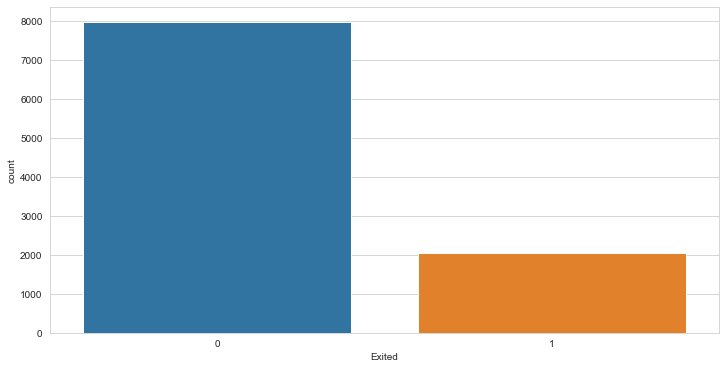

In [ ]:
print(df.Exited.value_counts())
sns.countplot(df["Exited"]);

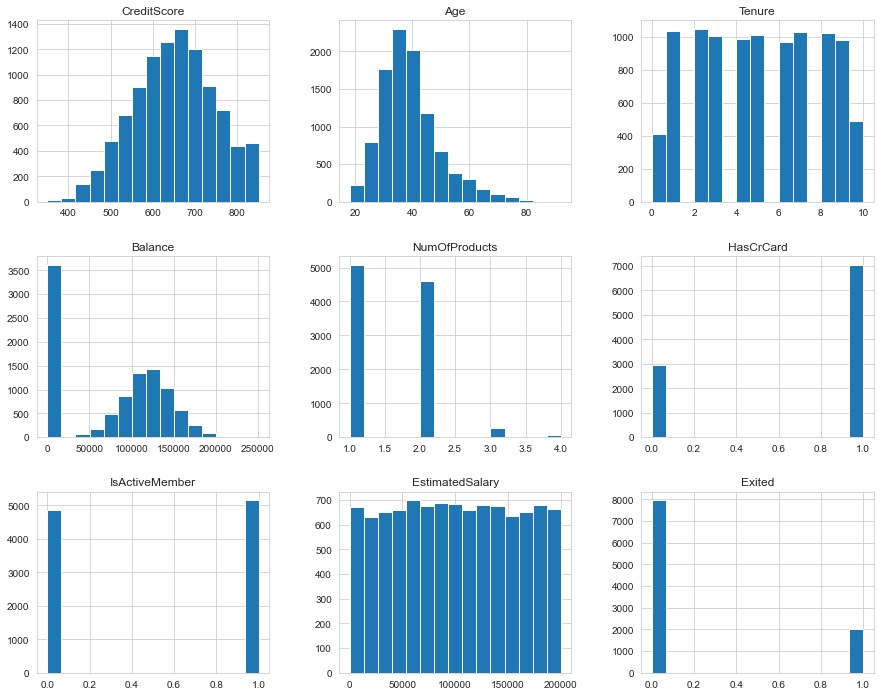

In [ ]:
df.hist(figsize=(15, 12), bins=15);


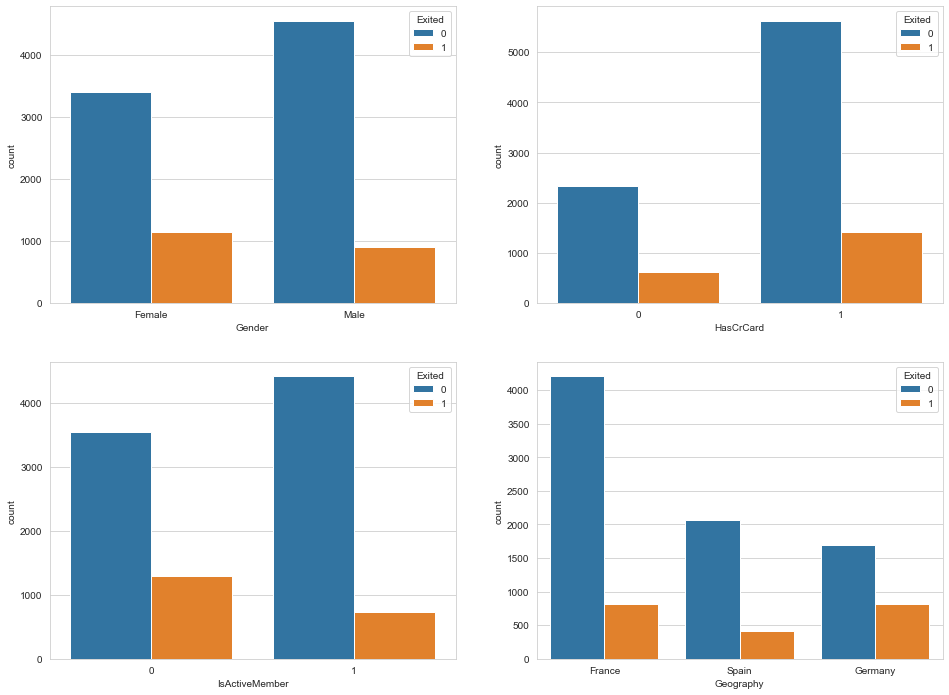

In [ ]:
cat_list = ["Gender", "HasCrCard", "IsActiveMember", "Geography"]
index = 0
plt.figure(figsize=(16, 12))
for i in cat_list:
    index += 1
    plt.subplot(2, 2, index)
    sns.countplot(data=df, x=i, hue="Exited")

In [ ]:
df.groupby("Age")["Exited"].value_counts()


Age  Exited
18   0         20
     1          2
19   0         26
     1          1
20   0         38
               ..
84   0          1
     1          1
85   0          1
88   0          1
92   0          2
Name: Exited, Length: 128, dtype: int64

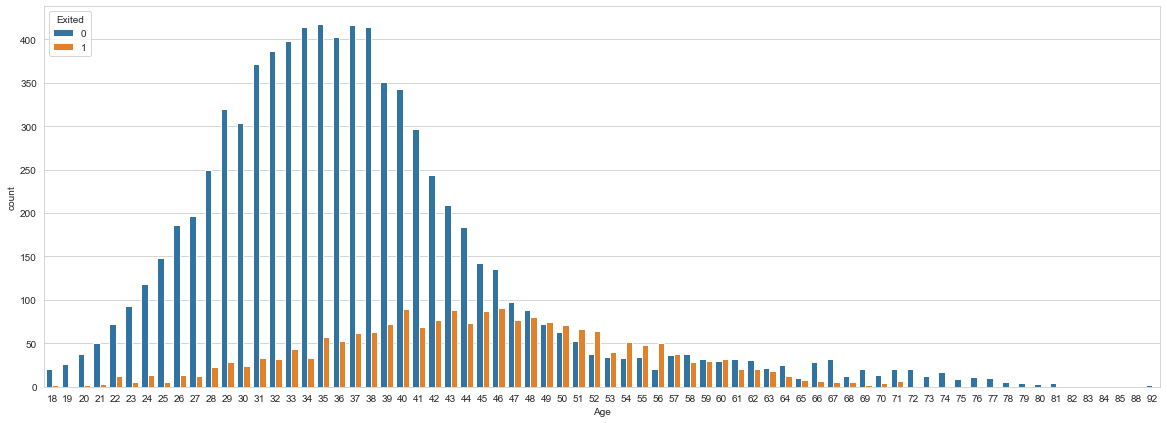

In [ ]:
plt.figure(figsize=(20, 7))
sns.countplot(df.Age, hue=df.Exited);

In [ ]:
df.CreditScore.describe()

count   10000.000
mean      650.529
std        96.653
min       350.000
25%       584.000
50%       652.000
75%       718.000
max       850.000
Name: CreditScore, dtype: float64

In [ ]:
def credit_transformer(x, y):
    if x < 584 and y == 0:
        return 0
    if x < 584 and y == 1:
        return 1
    if 584 < x < 718 and y == 0:
        return 2
    if 584 < x < 718 and y == 1:
        return 3
    else:
        return 4

In [ ]:
customer_value = [
    credit_transformer(x, y) for x, y in zip(df.CreditScore, df.HasCrCard)
]
customer_value[:10]

[3, 2, 1, 2, 4, 3, 4, 1, 0, 3]

In [ ]:
set(customer_value)

{0, 1, 2, 3, 4}

In [ ]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2,0.000,1,1,1,101348.880,1
2,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
3,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
4,699,France,Female,39,1,0.000,2,0,0,93826.630,0
5,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0
...,...,...,...,...,...,...,...,...,...,...,...
9996,771,France,Male,39,5,0.000,2,1,0,96270.640,0
9997,516,France,Male,35,10,57369.610,1,1,1,101699.770,0
9998,709,France,Female,36,7,0.000,1,0,1,42085.580,1


In [ ]:
df.insert(10, "customer_value", customer_value)

In [ ]:
df.customer_value

RowNumber
1        3
2        2
3        1
4        2
5        4
        ..
9996     4
9997     1
9998     2
9999     4
10000    4
Name: customer_value, Length: 10000, dtype: int64

from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()

result = encoder.fit_transform(df.customer_value.values.reshape(-1, 1))
print(result)


df.customer_value = result
df.customer_value

In [ ]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,customer_value,Exited
RowNumber,,,,,,,,,,,,
1,619,France,Female,42,2,0.000,1,1,1,101348.880,3,1
2,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,2,0
3,502,France,Female,42,8,159660.800,3,1,0,113931.570,1,1
4,699,France,Female,39,1,0.000,2,0,0,93826.630,2,0
5,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9996,771,France,Male,39,5,0.000,2,1,0,96270.640,4,0
9997,516,France,Male,35,10,57369.610,1,1,1,101699.770,1,0
9998,709,France,Female,36,7,0.000,1,0,1,42085.580,2,1


<AxesSubplot:>

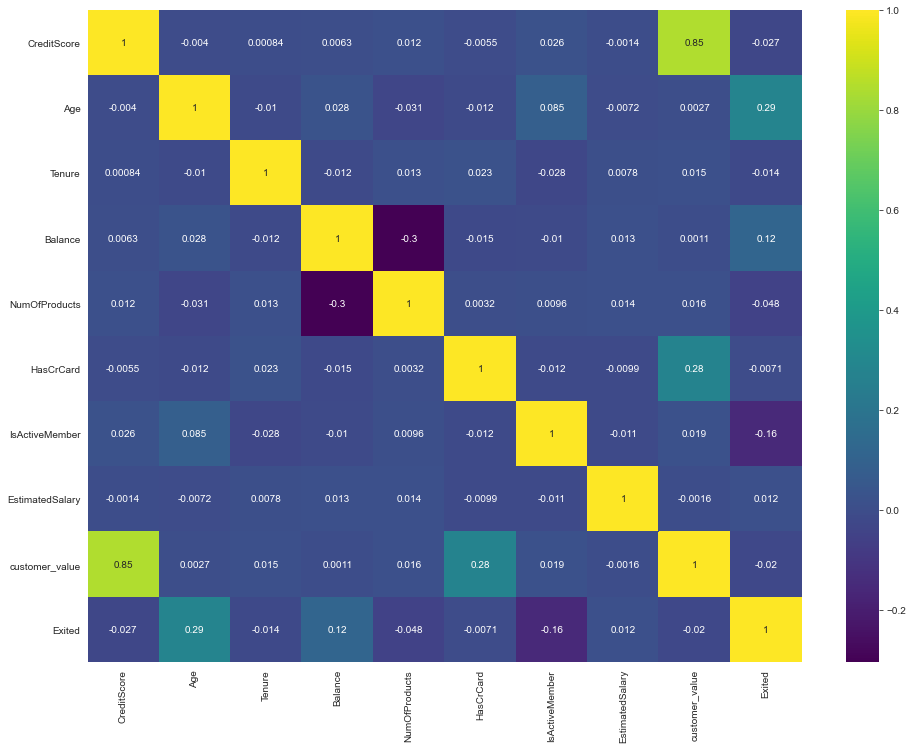

In [ ]:
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

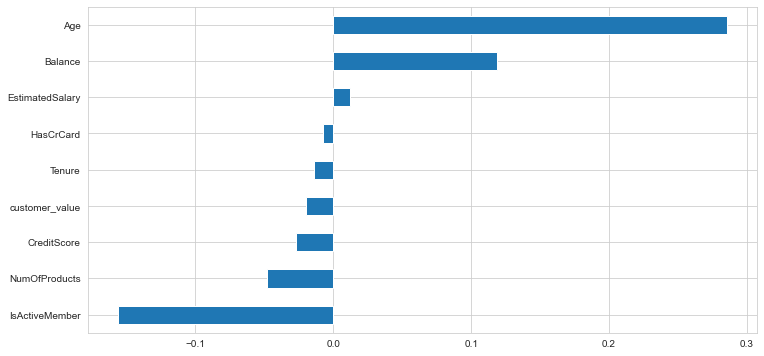

In [ ]:
df.corr()['Exited'][:-1].sort_values().plot.barh();

In [ ]:
df = pd.get_dummies(df)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,customer_value,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
RowNumber,,,,,,,,,,,,,,,
1,619,42,2,0.000,1,1,1,101348.880,3,1,1,0,0,1,0
2,608,41,1,83807.860,1,0,1,112542.580,2,0,0,0,1,1,0
3,502,42,8,159660.800,3,1,0,113931.570,1,1,1,0,0,1,0
4,699,39,1,0.000,2,0,0,93826.630,2,0,1,0,0,1,0
5,850,43,2,125510.820,1,1,1,79084.100,4,0,0,0,1,1,0


## Preprocessing of Data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
X = df.drop('Exited', axis=1)
y = df['Exited'].values

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.1,
                                                    random_state=42)


In [ ]:
scaler = MinMaxScaler()


In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modelling & Model Performance

<span class="mark">How many hidden layers should I use? : http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-9.html (mirror: http://francky.me/aifaq/FAQ-comp.ai.neural-net.pdf)
How many hidden units should I use? : http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-10.html (mirror: http://francky.me/aifaq/FAQ-comp.ai.neural-net.pdf)
What is genetic algorithm? : https://www.researchgate.net/post/What_is_genetic_algorithm1
Genetic algorithm + neural networks: http://francky.me/doc/mrf2011-HEC-ISIR-ENS_en.pdf (chapter 2.2)</span>

### without class_weigth

In [ ]:
model = Sequential()

model.add(Dense(30, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(15, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

opt = Adam(lr=0.001)
model.compile(optimizer=opt, 
              loss="binary_crossentropy",
              metrics=["Recall"])

<span class="burk">The patience is often set somewhere between 10 and 100 (10 or 20 is more common), but it really depends on your dataset and network.</span>

In [ ]:
early_stop = EarlyStopping(monitor="val_loss",
                           mode="auto",
                           verbose=1,
                           patience=30)

In [ ]:
model.fit(x=X_train,
          y=y_train,
          validation_split=.1,
          batch_size=128,
          epochs=500,
          verbose=1,
          callbacks=[early_stop])

Epoch 1/500
64/64 [==============================] - 3s 16ms/step - loss: 0.6931 - recall: 0.3747 - val_loss: 0.5348 - val_recall: 0.0000e+00
Epoch 2/500
64/64 [==============================] - 0s 5ms/step - loss: 0.5567 - recall: 0.0745 - val_loss: 0.4860 - val_recall: 0.0000e+00
Epoch 3/500
64/64 [==============================] - 0s 6ms/step - loss: 0.5396 - recall: 0.0357 - val_loss: 0.4736 - val_recall: 0.0000e+00
Epoch 4/500
64/64 [==============================] - 0s 5ms/step - loss: 0.5291 - recall: 0.0278 - val_loss: 0.4679 - val_recall: 0.0000e+00
Epoch 5/500
64/64 [==============================] - 0s 7ms/step - loss: 0.5205 - recall: 0.0212 - val_loss: 0.4660 - val_recall: 0.0000e+00
Epoch 6/500
64/64 [==============================] - 0s 6ms/step - loss: 0.5139 - recall: 0.0163 - val_loss: 0.4593 - val_recall: 0.0000e+00
Epoch 7/500
64/64 [==============================] - 0s 7ms/step - loss: 0.5099 - recall: 0.0097 - val_loss: 0.4558 - val_recall: 0.0000e+00
Epoch 8/500


Epoch 60/500
64/64 [==============================] - 0s 4ms/step - loss: 0.4015 - recall: 0.2863 - val_loss: 0.3368 - val_recall: 0.4309
Epoch 61/500
64/64 [==============================] - 0s 3ms/step - loss: 0.4005 - recall: 0.2778 - val_loss: 0.3333 - val_recall: 0.4420
Epoch 62/500
64/64 [==============================] - 0s 4ms/step - loss: 0.3982 - recall: 0.2809 - val_loss: 0.3337 - val_recall: 0.4530
Epoch 63/500
64/64 [==============================] - 0s 5ms/step - loss: 0.3966 - recall: 0.2887 - val_loss: 0.3368 - val_recall: 0.3867
Epoch 64/500
64/64 [==============================] - 0s 6ms/step - loss: 0.3994 - recall: 0.2778 - val_loss: 0.3338 - val_recall: 0.4475
Epoch 65/500
64/64 [==============================] - 0s 3ms/step - loss: 0.3954 - recall: 0.2881 - val_loss: 0.3295 - val_recall: 0.4641
Epoch 66/500
64/64 [==============================] - 0s 4ms/step - loss: 0.3965 - recall: 0.2918 - val_loss: 0.3324 - val_recall: 0.4309
Epoch 67/500
64/64 [==============

64/64 [==============================] - 0s 4ms/step - loss: 0.3815 - recall: 0.3335 - val_loss: 0.3176 - val_recall: 0.4475
Epoch 120/500
64/64 [==============================] - 0s 5ms/step - loss: 0.3816 - recall: 0.3335 - val_loss: 0.3159 - val_recall: 0.4530
Epoch 121/500
64/64 [==============================] - 0s 4ms/step - loss: 0.3839 - recall: 0.3293 - val_loss: 0.3197 - val_recall: 0.4420
Epoch 122/500
64/64 [==============================] - 0s 4ms/step - loss: 0.3840 - recall: 0.3075 - val_loss: 0.3179 - val_recall: 0.4420
Epoch 123/500
64/64 [==============================] - 0s 3ms/step - loss: 0.3803 - recall: 0.3281 - val_loss: 0.3184 - val_recall: 0.4475
Epoch 124/500
64/64 [==============================] - 0s 3ms/step - loss: 0.3831 - recall: 0.3166 - val_loss: 0.3182 - val_recall: 0.4586
Epoch 125/500
64/64 [==============================] - 0s 5ms/step - loss: 0.3786 - recall: 0.3335 - val_loss: 0.3188 - val_recall: 0.4530
Epoch 126/500
64/64 [====================

64/64 [==============================] - 0s 3ms/step - loss: 0.3821 - recall: 0.3166 - val_loss: 0.3130 - val_recall: 0.4696
Epoch 179/500
64/64 [==============================] - 0s 5ms/step - loss: 0.3777 - recall: 0.3390 - val_loss: 0.3143 - val_recall: 0.4530
Epoch 180/500
64/64 [==============================] - 0s 3ms/step - loss: 0.3767 - recall: 0.3487 - val_loss: 0.3138 - val_recall: 0.4696
Epoch 181/500
64/64 [==============================] - 0s 5ms/step - loss: 0.3753 - recall: 0.3293 - val_loss: 0.3092 - val_recall: 0.4696
Epoch 182/500
64/64 [==============================] - 0s 4ms/step - loss: 0.3797 - recall: 0.3487 - val_loss: 0.3161 - val_recall: 0.4530
Epoch 183/500
64/64 [==============================] - 0s 3ms/step - loss: 0.3766 - recall: 0.3335 - val_loss: 0.3102 - val_recall: 0.4641
Epoch 184/500
64/64 [==============================] - 0s 3ms/step - loss: 0.3775 - recall: 0.3317 - val_loss: 0.3128 - val_recall: 0.4420
Epoch 185/500
64/64 [====================

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 30)                450       
_________________________________________________________________
dropout_6 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 15)                465       
_________________________________________________________________
dropout_7 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 16        
Total params: 931
Trainable params: 931
Non-trainable params: 0
_________________________________________________________________


<AxesSubplot:>

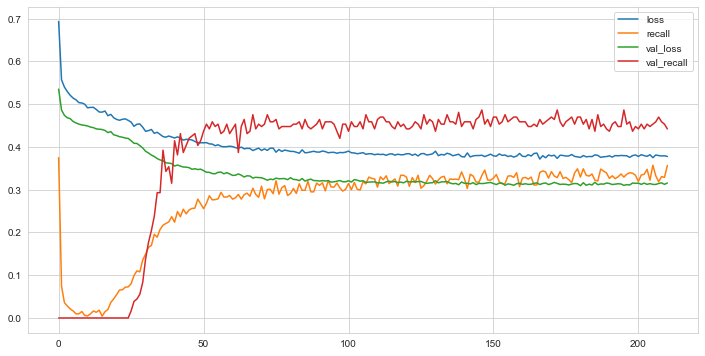

In [ ]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [ ]:
loss_df.nlargest(10, "val_recall")

,loss,recall,val_loss,val_recall
146,0.380,0.333,0.314,0.486
172,0.373,0.328,0.315,0.486
195,0.379,0.329,0.310,0.486
138,0.383,0.323,0.311,0.481
67,0.391,0.303,0.327,0.475
72,0.392,0.300,0.322,0.475
106,0.383,0.314,0.317,0.475
126,0.384,0.309,0.316,0.475
134,0.385,0.314,0.319,0.475
154,0.381,0.314,0.310,0.475


In [ ]:
loss_df

,loss,recall,val_loss,val_recall
0,0.693,0.375,0.535,0.000
1,0.557,0.074,0.486,0.000
2,0.540,0.036,0.474,0.000
3,0.529,0.028,0.468,0.000
4,0.520,0.021,0.466,0.000
...,...,...,...,...
206,0.381,0.332,0.312,0.459
207,0.380,0.318,0.314,0.470
208,0.379,0.331,0.316,0.459
209,0.379,0.329,0.312,0.453


In [ ]:
y_test_pred = (model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_test_pred))

NameError: name 'y_pred' is not defined

### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for model

In [ ]:
y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Keras Model')
plt.show()

In [ ]:
average_precision_score(y_test, y_pred_proba)

0.6781085311675284

### with class_weigth

In [ ]:
model_weighted = Sequential()

model_weighted.add(Dense(30, activation="relu"))
model_weighted.add(Dropout(0.5))
model_weighted.add(Dense(15, activation="relu"))
model_weighted.add(Dropout(0.5))
model_weighted.add(Dense(1, activation="sigmoid"))

opt = Adam(lr=0.001)
model_weighted.compile(optimizer=opt, 
                       loss="binary_crossentropy",
                       metrics=["Recall"])

In [ ]:
early_stop = EarlyStopping(monitor="val_loss",
                           mode="auto",
                           verbose=1,
                           patience=30)

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                   classes=np.unique(y_train),
                                                   y=y_train)

class_weights = {0: class_weights[0], 1: class_weights[1]}
class_weights

{0: 0.6278777731268314, 1: 2.454991816693944}

In [ ]:
model_weighted.fit(x=X_train,
                   y=y_train,
                   validation_split=.1,
                   batch_size=128,
                   epochs=200,
                   verbose=1,
                   callbacks=[early_stop],
                   class_weight=class_weights)

Epoch 1/200
64/64 [==============================] - 4s 20ms/step - loss: 0.7135 - recall: 0.4546 - val_loss: 0.6911 - val_recall: 0.6961
Epoch 2/200
64/64 [==============================] - 0s 7ms/step - loss: 0.6908 - recall: 0.4903 - val_loss: 0.6733 - val_recall: 0.6685
Epoch 3/200
64/64 [==============================] - 0s 7ms/step - loss: 0.6786 - recall: 0.5024 - val_loss: 0.6790 - val_recall: 0.7735
Epoch 4/200
64/64 [==============================] - 0s 8ms/step - loss: 0.6748 - recall: 0.5811 - val_loss: 0.6606 - val_recall: 0.7072
Epoch 5/200
64/64 [==============================] - 0s 7ms/step - loss: 0.6630 - recall: 0.6047 - val_loss: 0.6469 - val_recall: 0.6906
Epoch 6/200
64/64 [==============================] - 1s 8ms/step - loss: 0.6626 - recall: 0.6253 - val_loss: 0.6458 - val_recall: 0.6906
Epoch 7/200
64/64 [==============================] - 0s 7ms/step - loss: 0.6573 - recall: 0.6519 - val_loss: 0.6434 - val_recall: 0.7293
Epoch 8/200
64/64 [=====================

64/64 [==============================] - 0s 6ms/step - loss: 0.5065 - recall: 0.7712 - val_loss: 0.4547 - val_recall: 0.8619
Epoch 120/200
64/64 [==============================] - 0s 6ms/step - loss: 0.5078 - recall: 0.7694 - val_loss: 0.4425 - val_recall: 0.8564
Epoch 121/200
64/64 [==============================] - 0s 6ms/step - loss: 0.5074 - recall: 0.7633 - val_loss: 0.4346 - val_recall: 0.8398
Epoch 122/200
64/64 [==============================] - 0s 6ms/step - loss: 0.5108 - recall: 0.7609 - val_loss: 0.4568 - val_recall: 0.8619
Epoch 123/200
64/64 [==============================] - 0s 6ms/step - loss: 0.5050 - recall: 0.7663 - val_loss: 0.4619 - val_recall: 0.8674
Epoch 124/200
64/64 [==============================] - 0s 6ms/step - loss: 0.5078 - recall: 0.7772 - val_loss: 0.4296 - val_recall: 0.8398
Epoch 125/200
64/64 [==============================] - ETA: 0s - loss: 0.5139 - recall: 0.76 - 0s 6ms/step - loss: 0.5139 - recall: 0.7633 - val_loss: 0.4593 - val_recall: 0.8619
E

<AxesSubplot:>

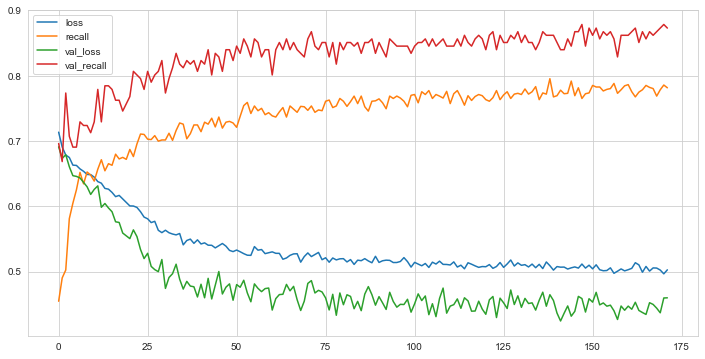

In [ ]:
loss_df = pd.DataFrame(model_weighted.history.history)
loss_df.plot()

In [ ]:
loss_df.nlargest(10, "val_recall")

,loss,recall,val_loss,val_recall
147,0.512,0.765,0.459,0.878
170,0.497,0.786,0.460,0.878
149,0.510,0.774,0.458,0.873
151,0.510,0.783,0.468,0.873
162,0.514,0.768,0.453,0.873
169,0.502,0.778,0.437,0.873
171,0.503,0.781,0.460,0.873
71,0.523,0.754,0.486,0.867
122,0.505,0.766,0.462,0.867
129,0.513,0.773,0.463,0.867


In [ ]:
loss_df 

,loss,recall,val_loss,val_recall
0,0.713,0.455,0.691,0.696
1,0.691,0.490,0.673,0.669
2,0.679,0.502,0.679,0.773
3,0.675,0.581,0.661,0.707
4,0.663,0.605,0.647,0.691
...,...,...,...,...
167,0.506,0.780,0.450,0.862
168,0.505,0.769,0.444,0.867
169,0.502,0.778,0.437,0.873
170,0.497,0.786,0.460,0.878


In [ ]:
y_test_pred = (model_weighted.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[541 255]
 [ 39 165]]
              precision    recall  f1-score   support

           0       0.93      0.68      0.79       796
           1       0.39      0.81      0.53       204

    accuracy                           0.71      1000
   macro avg       0.66      0.74      0.66      1000
weighted avg       0.82      0.71      0.73      1000



### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for model

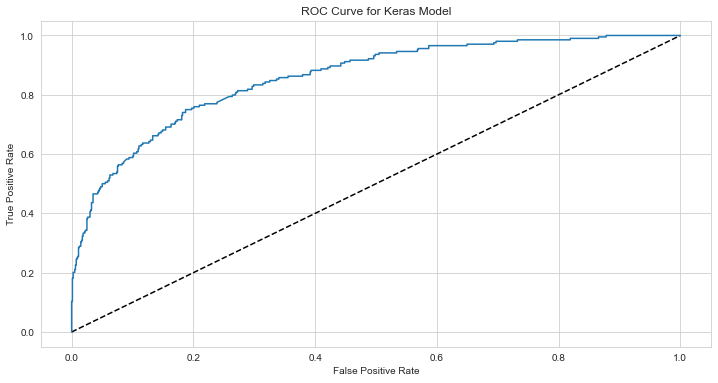

In [ ]:
y_pred_proba = model_weighted.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Keras Model')
plt.show()

In [ ]:
average_precision_score(y_test, y_pred_proba)

0.6781085311675284

## GridSearchCV

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
def build_classifier(optimizer):
    
    classifier = Sequential()
    classifier.add(Dense(30, activation="relu"))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(15, activation="relu"))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(1, activation="sigmoid"))
    
    classifier.compile(optimizer=optimizer,
                       loss='binary_crossentropy',
                       metrics=['Recall'])
    return classifier

In [ ]:
class_weights

{0: 0.6278777731268314, 1: 2.454991816693944}

In [ ]:
classifier = KerasClassifier(build_fn=build_classifier, epochs=150)
parameters = {'batch_size': [128, 256],
              'optimizer': [Adam, 'rmsprop', "SGD", "adagrad", "adadelta"]}

grid_model = GridSearchCV(estimator=classifier,
                          param_grid=parameters,
                          scoring='recall',
                          cv=5,
                          n_jobs=-1,
                          verbose=0).fit(X_train, y_train, class_weight=class_weights)

Epoch 1/150
71/71 [==============================] - 4s 6ms/step - loss: 0.7106 - recall: 0.4501
Epoch 2/150
71/71 [==============================] - 0s 5ms/step - loss: 0.6879 - recall: 0.5548
Epoch 3/150
71/71 [==============================] - 0s 5ms/step - loss: 0.6737 - recall: 0.6241
Epoch 4/150
71/71 [==============================] - 0s 5ms/step - loss: 0.6732 - recall: 0.6170
Epoch 5/150
71/71 [==============================] - 0s 5ms/step - loss: 0.6655 - recall: 0.6459
Epoch 6/150
71/71 [==============================] - 0s 5ms/step - loss: 0.6602 - recall: 0.6508
Epoch 7/150
71/71 [==============================] - 0s 5ms/step - loss: 0.6579 - recall: 0.6438
Epoch 8/150
71/71 [==============================] - 0s 5ms/step - loss: 0.6534 - recall: 0.6912
Epoch 9/150
71/71 [==============================] - 0s 5ms/step - loss: 0.6506 - recall: 0.6863
Epoch 10/150
71/71 [==============================] - 0s 5ms/step - loss: 0.6492 - recall: 0.6476
Epoch 11/150
71/71 [=========

In [ ]:
grid_model.best_score_

0.7295568848044429

In [ ]:
grid_model.best_params_

{'batch_size': 128, 'optimizer': 'rmsprop'}

In [ ]:
y_test_pred = (grid_model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[622 174]
 [ 53 151]]
              precision    recall  f1-score   support

           0       0.92      0.78      0.85       796
           1       0.46      0.74      0.57       204

    accuracy                           0.77      1000
   macro avg       0.69      0.76      0.71      1000
weighted avg       0.83      0.77      0.79      1000



### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for grid_model

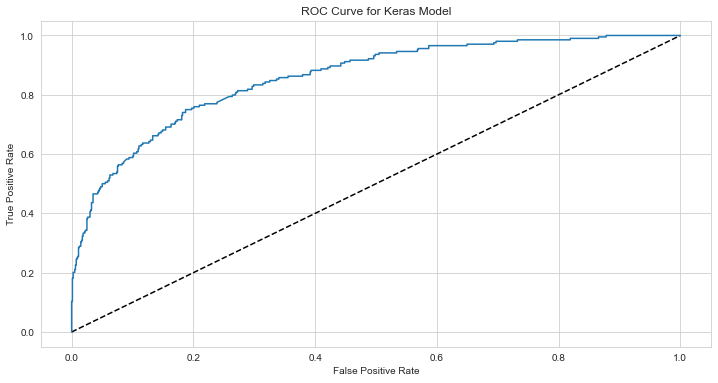

In [ ]:
y_pred_proba = grid_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Keras Model')
plt.show()

In [ ]:
average_precision_score(y_test, y_pred_proba)

0.6781085311675284

## Final Model and Model Deployment

In [ ]:
import pickle

pickle.dump(scaler, open("scaler_churn", 'wb'))

In [ ]:
final_model = Sequential()


final_model.add(Dense(30, activation="relu"))
final_model.add(Dropout(0.5))
final_model.add(Dense(15, activation="relu"))
final_model.add(Dropout(0.5))
final_model.add(Dense(1, activation="sigmoid"))

final_model.compile(optimizer="rmsprop",
                    loss="binary_crossentropy",
                    metrics=["Recall"])

final_model.fit(x=X_train,
                y=y_train,
                validation_data=(X_test, y_test),
                callbacks=[early_stop],
                batch_size=128,
                epochs=200,
                verbose=1,
                class_weight=class_weights)

Epoch 1/200
71/71 [==============================] - 4s 17ms/step - loss: 0.7042 - recall: 0.5303 - val_loss: 0.6908 - val_recall: 0.7059
Epoch 2/200
71/71 [==============================] - 0s 6ms/step - loss: 0.6850 - recall: 0.5554 - val_loss: 0.6756 - val_recall: 0.6471
Epoch 3/200
71/71 [==============================] - 0s 6ms/step - loss: 0.6762 - recall: 0.5630 - val_loss: 0.6642 - val_recall: 0.5931
Epoch 4/200
71/71 [==============================] - 0s 6ms/step - loss: 0.6688 - recall: 0.5516 - val_loss: 0.6651 - val_recall: 0.5980
Epoch 5/200
71/71 [==============================] - 0s 7ms/step - loss: 0.6650 - recall: 0.5674 - val_loss: 0.6525 - val_recall: 0.5833
Epoch 6/200
71/71 [==============================] - 1s 7ms/step - loss: 0.6600 - recall: 0.5636 - val_loss: 0.6579 - val_recall: 0.5980
Epoch 7/200
71/71 [==============================] - 0s 6ms/step - loss: 0.6526 - recall: 0.5723 - val_loss: 0.6504 - val_recall: 0.6029
Epoch 8/200
71/71 [=====================

71/71 [==============================] - 0s 6ms/step - loss: 0.5171 - recall: 0.7092 - val_loss: 0.4698 - val_recall: 0.7500
Epoch 120/200
71/71 [==============================] - 0s 7ms/step - loss: 0.5144 - recall: 0.7190 - val_loss: 0.4842 - val_recall: 0.7647
Epoch 121/200
71/71 [==============================] - 0s 7ms/step - loss: 0.5135 - recall: 0.7114 - val_loss: 0.4785 - val_recall: 0.7500
Epoch 122/200
71/71 [==============================] - 0s 6ms/step - loss: 0.5118 - recall: 0.7043 - val_loss: 0.4724 - val_recall: 0.7353
Epoch 123/200
71/71 [==============================] - 0s 6ms/step - loss: 0.5134 - recall: 0.7027 - val_loss: 0.4997 - val_recall: 0.7794
Epoch 124/200
71/71 [==============================] - 0s 6ms/step - loss: 0.5135 - recall: 0.7234 - val_loss: 0.4800 - val_recall: 0.7549
Epoch 125/200
71/71 [==============================] - 0s 6ms/step - loss: 0.5126 - recall: 0.7212 - val_loss: 0.4829 - val_recall: 0.7549
Epoch 126/200
71/71 [====================

71/71 [==============================] - 0s 7ms/step - loss: 0.5090 - recall: 0.6983 - val_loss: 0.4617 - val_recall: 0.7353
Epoch 179/200
71/71 [==============================] - ETA: 0s - loss: 0.5081 - recall: 0.70 - 0s 6ms/step - loss: 0.5070 - recall: 0.7010 - val_loss: 0.4712 - val_recall: 0.7353
Epoch 180/200
71/71 [==============================] - 0s 6ms/step - loss: 0.5024 - recall: 0.6994 - val_loss: 0.4645 - val_recall: 0.7647
Epoch 181/200
71/71 [==============================] - 0s 6ms/step - loss: 0.5100 - recall: 0.7049 - val_loss: 0.4525 - val_recall: 0.7402
Epoch 182/200
71/71 [==============================] - 0s 6ms/step - loss: 0.5079 - recall: 0.6961 - val_loss: 0.4532 - val_recall: 0.7353
Epoch 183/200
71/71 [==============================] - 0s 6ms/step - loss: 0.5130 - recall: 0.7316 - val_loss: 0.4559 - val_recall: 0.7549
Epoch 184/200
71/71 [==============================] - 0s 6ms/step - loss: 0.5079 - recall: 0.7381 - val_loss: 0.4492 - val_recall: 0.7304
E

<AxesSubplot:>

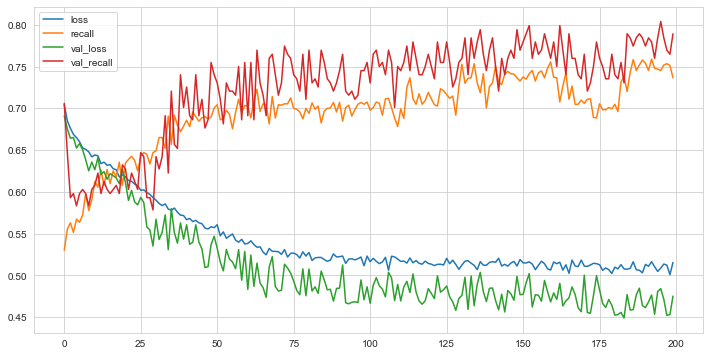

In [ ]:
loss_df = pd.DataFrame(final_model.history.history)
loss_df.plot()

In [ ]:
loss_df

,loss,recall,val_loss,val_recall
0,0.704,0.530,0.691,0.706
1,0.685,0.555,0.676,0.647
2,0.676,0.563,0.664,0.593
3,0.669,0.552,0.665,0.598
4,0.665,0.567,0.652,0.583
...,...,...,...,...
195,0.509,0.745,0.484,0.804
196,0.514,0.752,0.471,0.784
197,0.512,0.753,0.452,0.770
198,0.501,0.751,0.453,0.765


In [ ]:
loss_df.nlargest(10, "val_recall")

,loss,recall,val_loss,val_recall
195,0.509,0.745,0.484,0.804
152,0.516,0.741,0.502,0.799
162,0.516,0.708,0.491,0.799
136,0.517,0.718,0.504,0.794
148,0.511,0.736,0.499,0.794
151,0.515,0.735,0.491,0.789
157,0.514,0.736,0.494,0.789
165,0.503,0.711,0.473,0.789
184,0.507,0.720,0.477,0.789
188,0.506,0.752,0.485,0.789


In [ ]:
y_test_pred = (final_model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[602 194]
 [ 43 161]]
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       796
           1       0.45      0.79      0.58       204

    accuracy                           0.76      1000
   macro avg       0.69      0.77      0.71      1000
weighted avg       0.84      0.76      0.78      1000



In [ ]:
final_model.save('model_churn.h5')

### Prediction

In [ ]:
single_customer = df.drop('Exited', axis=1).iloc[0]
single_customer

CreditScore            619.000
Age                     42.000
Tenure                   2.000
Balance                  0.000
NumOfProducts            1.000
HasCrCard                1.000
IsActiveMember           1.000
EstimatedSalary     101348.880
customer_value           3.000
Geography_France         1.000
Geography_Germany        0.000
Geography_Spain          0.000
Gender_Female            1.000
Gender_Male              0.000
Name: 1, dtype: float64

In [ ]:
single_customer = scaler.transform(single_customer.values.reshape(-1, 14))
single_customer

array([[0.538     , 0.32432432, 0.2       , 0.        , 0.        ,
        1.        , 1.        , 0.50673489, 0.75      , 1.        ,
        0.        , 0.        , 1.        , 0.        ]])

In [ ]:
(final_model.predict(single_customer) > 0.5).astype("int32")

array([[1]])

In [ ]:
df["Exited"].iloc[0]

1

---
---

## Comparison with ML

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
clf1 = RandomForestClassifier(random_state=42, class_weight="balanced")
clf2 = SVC(probability=True, random_state=42, class_weight="balanced")
clf3 = LogisticRegression(random_state=42, class_weight="balanced")

In [ ]:
# Initiaze the hyperparameters for each dictionary
param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__max_depth'] = [5, 10, 20]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__C'] = [10**(-2+i) for i in range(5)]
param2['classifier'] = [clf2]

param3 = {}
param3['classifier__C'] = [10**(-2+i) for i in range(5)]
param3['classifier__penalty'] = ['l1', 'l2']
param3['classifier'] = [clf3]

In [ ]:
pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2, param3]

In [ ]:
grid_model = GridSearchCV(pipeline, params, cv=5, n_jobs=-1,
                          scoring='recall').fit(X_train, y_train)

In [ ]:
grid_model.best_params_

In [ ]:
grid_model.best_score_

In [ ]:
y_pred_proba = grid_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Keras Model')
plt.show()

In [ ]:
average_precision_score(y_test, y_pred_proba)

In [ ]:
y_test_pred = (grid_model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

# SVC

In [ ]:
pipeline = Pipeline([('classifier', clf2)])
params = [param1, param2, param3]

In [ ]:
grid_model = GridSearchCV(pipeline, params, cv=5, n_jobs=-1,
                          scoring='recall').fit(X_train, y_train)

In [ ]:
grid_model.best_params_

In [ ]:
grid_model.best_score_

In [ ]:
y_pred_proba = grid_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Keras Model')
plt.show()

In [ ]:
average_precision_score(y_test, y_pred_proba)

In [ ]:
y_test_pred = (grid_model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

# LR

In [ ]:
pipeline = Pipeline([('classifier', clf3)])
params = [param1, param2, param3]

In [ ]:
grid_model = GridSearchCV(pipeline, params, cv=5, n_jobs=-1,
                          scoring='recall').fit(X_train, y_train)

In [ ]:
grid_model.best_params_

In [ ]:
grid_model.best_score_

In [ ]:
y_pred_proba = grid_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Keras Model')
plt.show()

In [ ]:
average_precision_score(y_test, y_pred_proba)

In [ ]:
y_test_pred = (grid_model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

---
---